In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX





In [4]:
# Clean and compatible setup
!pip uninstall -y numpy pmdarima
!pip install numpy==1.26.4
!pip install pmdarima --no-binary :all:


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


  Using cached pmdarima-2.0.4.tar.gz (630 kB)
  Installing build dependencies ... canceled
^C


In [2]:
!pip install pmdarima


  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)


# Load and explore the data

In [37]:
df = pd.read_csv('project_dataset.csv')

# Filter by Department 3
df_dept3 = df[df['Dept'] == 3]

# Convert Date to datetime
df_dept3['Date'] = pd.to_datetime(df_dept3['Date'])

# Sort by date
df_dept3 = df_dept3.sort_values('Date')

# Set Date as index
df_dept3.set_index('Date', inplace=True)

# Show first few rows
print(df_dept3.head())

# Check basic info
print(df_dept3.info())


            IsHoliday  Dept  Weekly_Sales  Temperature  Fuel_Price  \
Date                                                                 
2010-02-05          0   3.0      13740.12        42.31       2.572   
2010-02-12          1   3.0      10887.84        38.51       2.548   
2010-02-19          0   3.0      11523.47        39.93       2.514   
2010-02-26          0   3.0      11135.17        46.63       2.561   
2010-03-05          0   3.0      12275.58        46.50       2.625   

                   CPI  Unemployment  
Date                                  
2010-02-05  211.096358         8.106  
2010-02-12  211.242170         8.106  
2010-02-19  211.289143         8.106  
2010-02-26  211.319643         8.106  
2010-03-05  211.350143         8.106  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-02-05 to 2012-10-26
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   IsHoliday     143 non-

/tmp/ipython-input-37-266585908.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dept3['Date'] = pd.to_datetime(df_dept3['Date'])


# Visualization

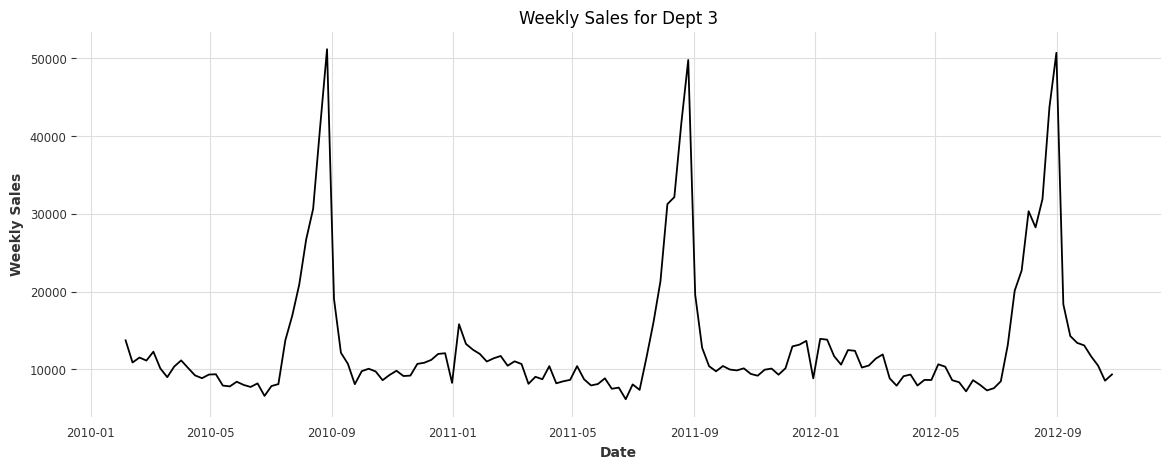

In [38]:
#Weekly Sales Over Time
plt.figure(figsize=(14, 5))
plt.plot(df_dept3['Weekly_Sales'])
plt.title('Weekly Sales for Dept 3')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

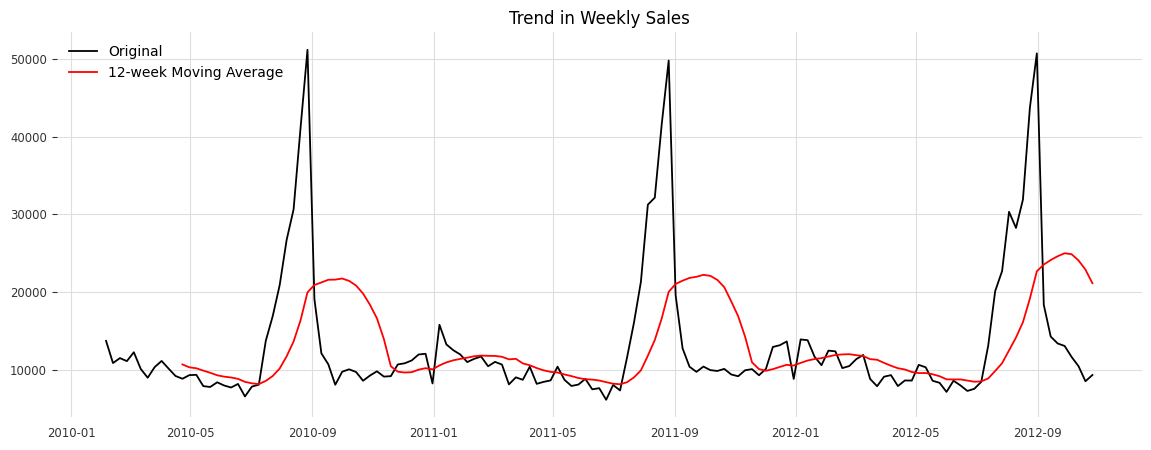

In [39]:
#Trends and Seasonality (Moving Average)
df_dept3['Weekly_Sales_MA_12'] = df_dept3['Weekly_Sales'].rolling(window=12).mean()

plt.figure(figsize=(14, 5))
plt.plot(df_dept3['Weekly_Sales'], label='Original')
plt.plot(df_dept3['Weekly_Sales_MA_12'], label='12-week Moving Average', color='red')
plt.legend()
plt.title('Trend in Weekly Sales')
plt.show()

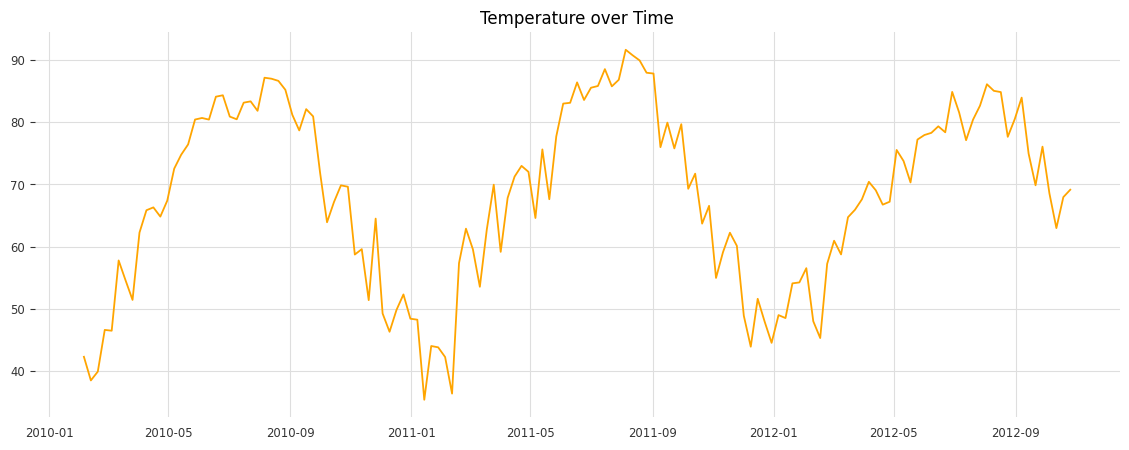

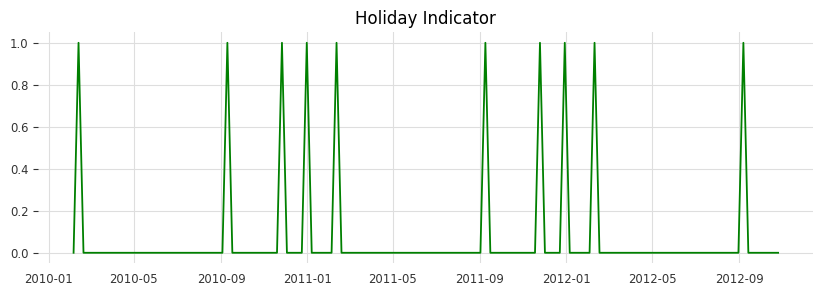

In [40]:
#Plot External Regressors
plt.figure(figsize=(14, 5))
plt.plot(df_dept3['Temperature'], label='Temperature', color='orange')
plt.title('Temperature over Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(df_dept3['IsHoliday'], label='IsHoliday', color='green')
plt.title('Holiday Indicator')
plt.grid(True)
plt.show()


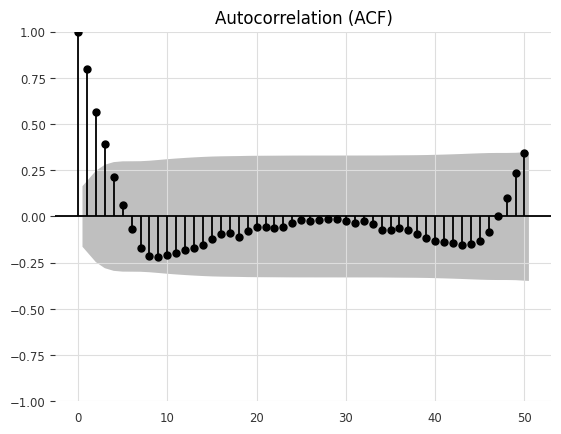

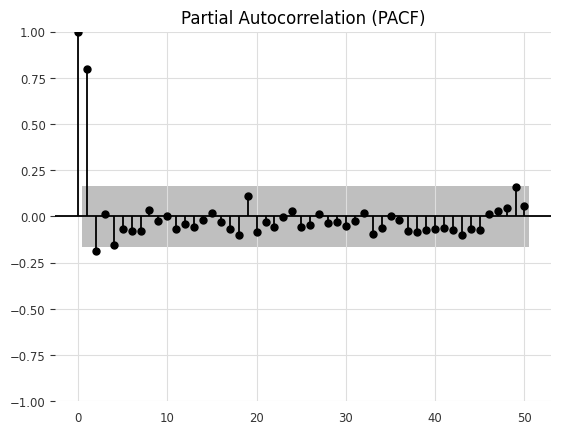

In [41]:
#Plot ACF and PACF

plot_acf(df_dept3['Weekly_Sales'], lags=50)
plt.title("Autocorrelation (ACF)")
plt.show()

plot_pacf(df_dept3['Weekly_Sales'], lags=50, method='ywm')
plt.title("Partial Autocorrelation (PACF)")
plt.show()


# Exponential Smoothing Models


In [42]:
# Prepare Data (Train-Test Split)
# Use last 12 weeks as test set (adjust if needed)
train = df_dept3.iloc[:-12]
test = df_dept3.iloc[-12:]

print("Train size:", train.shape)
print("Test size:", test.shape)

Train size: (131, 8)
Test size: (12, 8)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


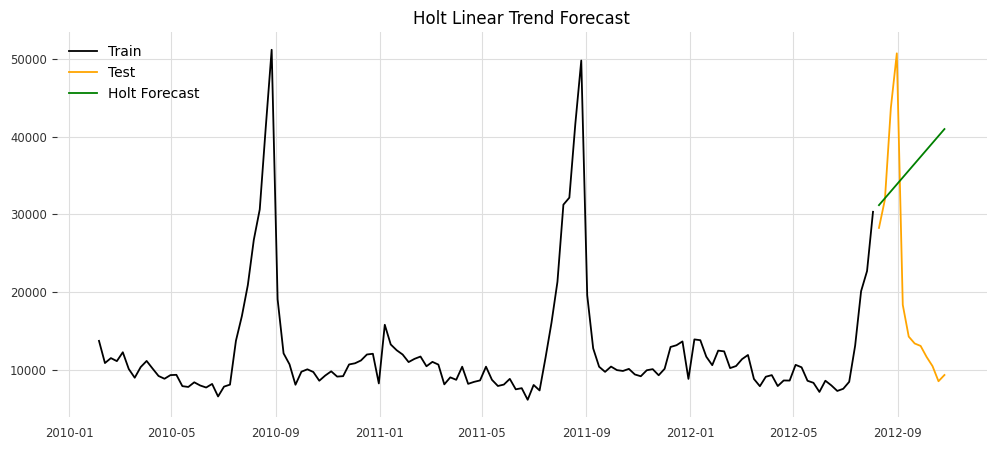

In [43]:
# Holt’s Linear Trend Method (No Seasonality)
model_holt = Holt(train['Weekly_Sales']).fit()
pred_holt = model_holt.forecast(len(test))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(train['Weekly_Sales'], label='Train')
plt.plot(test['Weekly_Sales'], label='Test', color='orange')
plt.plot(pred_holt, label='Holt Forecast', color='green')
plt.legend()
plt.title('Holt Linear Trend Forecast')
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


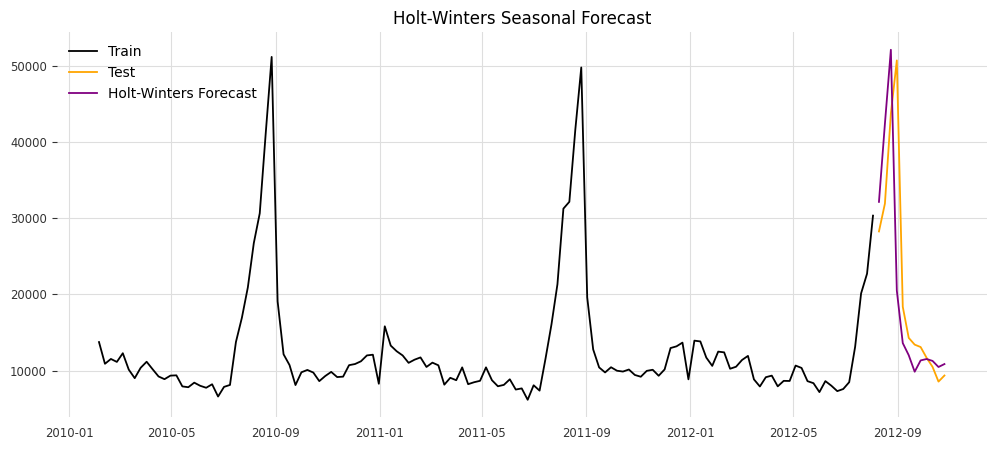

In [44]:
# Holt-Winters Seasonal Method (Additive or Multiplicative)
# Additive seasonality
model_hw = ExponentialSmoothing(train['Weekly_Sales'], trend='add', seasonal='add', seasonal_periods=52).fit()
pred_hw = model_hw.forecast(len(test))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(train['Weekly_Sales'], label='Train')
plt.plot(test['Weekly_Sales'], label='Test', color='orange')
plt.plot(pred_hw, label='Holt-Winters Forecast', color='purple')
plt.legend()
plt.title('Holt-Winters Seasonal Forecast')
plt.show()

In [45]:

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape



In [46]:
print("Holt:", evaluate(test['Weekly_Sales'], pred_holt))
print("Holt-Winters:", evaluate(test['Weekly_Sales'], pred_hw))

Holt: (21953.99764172723, 19526.556144792172, 156.17840153392768)
Holt-Winters: (9821.13610312138, 5804.871419068161, 21.20391564376366)


# ARIMA Family Models


In [47]:
# Check Stationarity
result = adfuller(train['Weekly_Sales'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -4.479860671444748
p-value: 0.000213789782982787


In [48]:
#data is stationary

In [49]:
# Fit ARIMA Model (No Seasonality)
auto_model = auto_arima(train['Weekly_Sales'], seasonal=False, trace=True)
print(auto_model.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2602.351, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2885.922, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2599.921, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2755.517, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2600.102, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2599.864, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2600.340, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2601.296, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2699.926, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2587.756, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2629.376, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2590.551, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2588.809, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2589.606, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2719.298, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2630.768, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2586.891, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2588.601, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2590.371, Time=0.16 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.550 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  131
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1289.446
Date:                Thu, 26 Jun 2025   AIC                           2586.891
Time:                        10:21:39   BIC                           2598.392
Sample:                    02-05-2010   HQIC                          2591.565
                         - 08-03-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
i

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


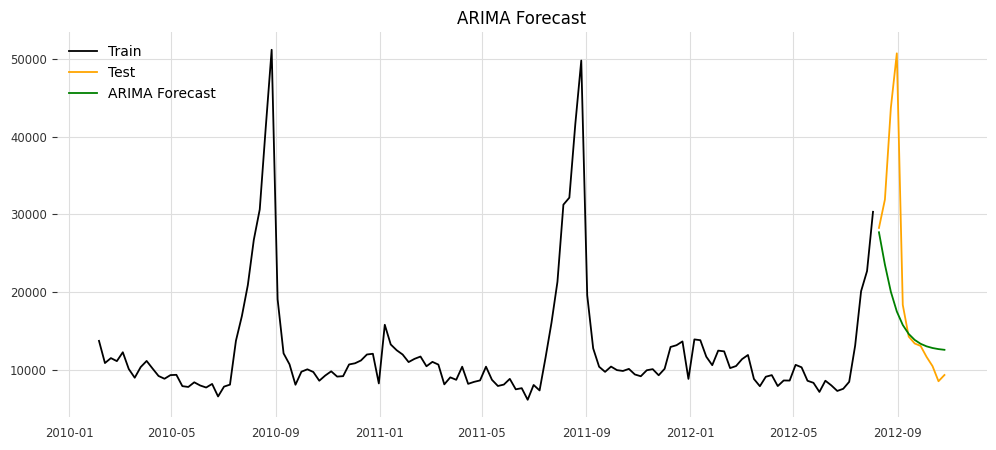

In [50]:
model_arima = ARIMA(train['Weekly_Sales'], order=auto_model.order).fit()
pred_arima = model_arima.forecast(steps=len(test))

# Plot
plt.figure(figsize=(12,5))
plt.plot(train['Weekly_Sales'], label='Train')
plt.plot(test['Weekly_Sales'], label='Test', color='orange')
plt.plot(pred_arima, label='ARIMA Forecast', color='green')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()


In [51]:
# Fit SARIMA (Add Seasonality)
auto_model_seasonal = auto_arima(train['Weekly_Sales'], seasonal=True, m=52, trace=True)
print(auto_model_seasonal.summary())


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=inf, Time=27.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1366.885, Time=0.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1350.801, Time=7.62 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1338.877, Time=13.94 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1343.896, Time=3.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1340.853, Time=30.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,2)[52]             : AIC=1340.853, Time=58.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1341.910, Time=5.64 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,2)[52]             : AIC=1345.897, Time=22.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,1)[52]             : AIC=1359.686, Time=2.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,1)[52]             : AIC=inf, Time=23.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,1)[52]             : AIC=inf, Time=16.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[52]             : AIC=1350.720, Time=4.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,1)[52]             : AIC=inf, Time=20.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[52] intercept   : AIC=1340.877, Time=15.02 sec

Best model:  ARIMA(0,1,1)(0,1,1)[52]          
Total fit time: 252.165 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  131
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -666.439
Date:                            Thu, 26 Jun 2025   AIC                           1338.877
Time:                                    10:25:51   BIC                           1345.948
Sample:                                02-05-2010   HQIC                          1341.708
                                     - 08-03-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

In [52]:
model_sarima = SARIMAX(train['Weekly_Sales'], order=auto_model_seasonal.order,
                       seasonal_order=auto_model_seasonal.seasonal_order).fit()
pred_sarima = model_sarima.forecast(steps=len(test))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [53]:
# Fit SARIMAX (with external regressors)
exog_train = train[['Temperature', 'IsHoliday']]
exog_test = test[['Temperature', 'IsHoliday']]

model_sarimax = SARIMAX(train['Weekly_Sales'],
                        exog=exog_train,
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 52)).fit()

pred_sarimax = model_sarimax.forecast(steps=len(test), exog=exog_test)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:

In [54]:
# Compare All Models
print("ARIMA:", evaluate(test['Weekly_Sales'], pred_arima))
print("SARIMA:", evaluate(test['Weekly_Sales'], pred_sarima))
print("SARIMAX:", evaluate(test['Weekly_Sales'], pred_sarimax))



ARIMA: (12157.132961108695, 6707.44824716514, 23.8807444556902)
SARIMA: (9707.892919288895, 5719.020073444798, 21.027127913003888)
SARIMAX: (9716.271080709264, 5605.415814352506, 20.69785831599074)


# Machine Learning Regressors (Random Forest, XGBoost)

In [55]:
#Create Features for Supervised Learning
df_ml = df_dept3.copy()
df_ml['Week'] = df_ml.index.isocalendar().week
df_ml['Month'] = df_ml.index.month
df_ml['Year'] = df_ml.index.year
df_ml['Lag_1'] = df_ml['Weekly_Sales'].shift(1)
df_ml['Lag_2'] = df_ml['Weekly_Sales'].shift(2)
df_ml['Lag_3'] = df_ml['Weekly_Sales'].shift(3)
df_ml = df_ml.dropna()


In [56]:
# Split to Train/Test
train_ml = df_ml.iloc[:-12]
test_ml = df_ml.iloc[-12:]

features = ['Lag_1', 'Lag_2', 'Lag_3', 'Temperature', 'IsHoliday', 'Week', 'Month', 'Year']
target = 'Weekly_Sales'

X_train = train_ml[features]
y_train = train_ml[target]
X_test = test_ml[features]
y_test = test_ml[target]


In [57]:
# Train Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
pred_rf = rf_model.predict(X_test)

print("Random Forest:", evaluate(y_test, pred_rf))


Random Forest: (5951.58929821522, 3910.703466666668, 14.438042520524109)


In [58]:
# Train XGBoost Regressor
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
pred_xgb = xgb_model.predict(X_test)

print("XGBoost:", evaluate(y_test, pred_xgb))

XGBoost: (2373.4629716633067, 1673.6291080729163, 8.267850428642038)


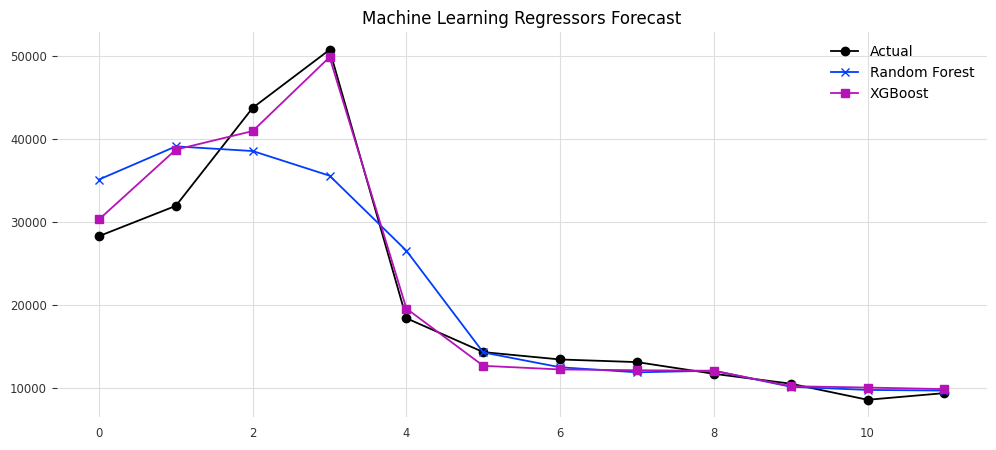

In [59]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(pred_rf, label='Random Forest', marker='x')
plt.plot(pred_xgb, label='XGBoost', marker='s')
plt.title('Machine Learning Regressors Forecast')
plt.legend()
plt.show()


In [60]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler


# Deep Learning Models

In [61]:
# Prepare Data for Deep Learning
# Lag 3 weeks as input
# Predict 1 week ahead

# Scale the data
scaler = MinMaxScaler()
df_dl = df_ml.copy()
df_dl[features + [target]] = scaler.fit_transform(df_dl[features + [target]])

# Create supervised dataset
X = df_dl[features].values
y = df_dl[target].values

X_seq = []
y_seq = []
for i in range(3, len(X)):  # 3 lags
    X_seq.append(X[i-3:i])  # past 3 weeks
    y_seq.append(y[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Train/test split
X_train_dl = X_seq[:-12]
y_train_dl = y_seq[:-12]
X_test_dl = X_seq[-12:]
y_test_dl = y_seq[-12:]

In [62]:
# ANN Model (Flattened input)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model_ann = Sequential([
    Flatten(input_shape=(3, X_seq.shape[2])),
    Dense(64, activation='relu'),
    Dense(1)
])

model_ann.compile(optimizer='adam', loss='mse')
model_ann.fit(X_train_dl, y_train_dl, epochs=50, verbose=0)

pred_ann = model_ann.predict(X_test_dl).flatten()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


In [64]:
# LSTM Model
from tensorflow.keras.layers import LSTM

model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(3, X_seq.shape[2])),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_dl, y_train_dl, epochs=50, verbose=0)

pred_lstm = model_lstm.predict(X_test_dl).flatten()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


In [65]:
# Get last timestep features (shape: [12, 8])
last_features = X_test_dl[:, -1, :]  # already 8 features

# Stack predicted sales as the 9th column (target)
ann_combined = np.hstack([last_features, pred_ann.reshape(-1, 1)])
lstm_combined = np.hstack([last_features, pred_lstm.reshape(-1, 1)])
true_combined = np.hstack([last_features, y_test_dl.reshape(-1, 1)])

# Now inverse-transform
pred_ann_inv = scaler.inverse_transform(ann_combined)[:, -1]
pred_lstm_inv = scaler.inverse_transform(lstm_combined)[:, -1]
y_true_inv = scaler.inverse_transform(true_combined)[:, -1]


In [66]:
print("ANN:", evaluate(y_true_inv, pred_ann_inv))
print("LSTM:", evaluate(y_true_inv, pred_lstm_inv))


ANN: (10803.77746679134, 7331.746063111425, 31.58720025945641)
LSTM: (10600.93386488138, 7745.686841513018, 37.786699686343184)


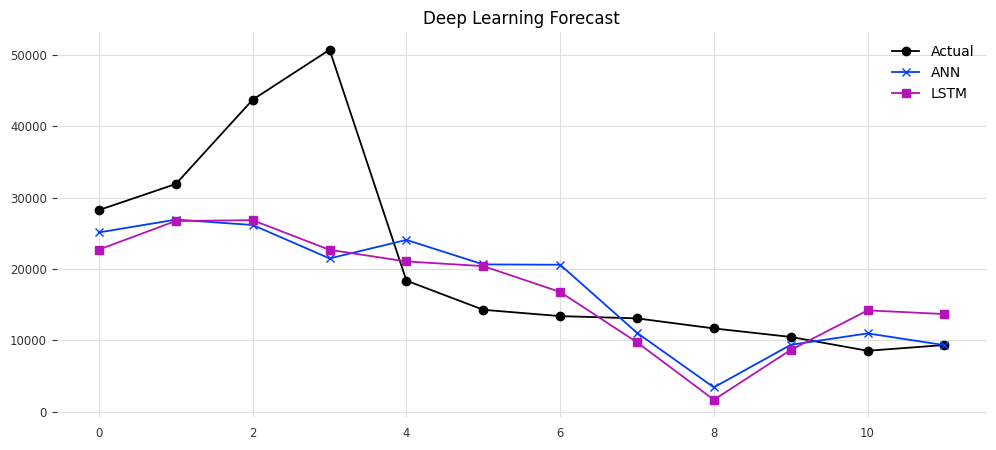

In [67]:
plt.figure(figsize=(12, 5))
plt.plot(y_true_inv, label='Actual', marker='o')
plt.plot(pred_ann_inv, label='ANN', marker='x')
plt.plot(pred_lstm_inv, label='LSTM', marker='s')
plt.title('Deep Learning Forecast')
plt.legend()
plt.show()


# orecasting with Facebook Prophet


In [68]:
pip install prophet


In [69]:
#Prepare Data for Prophet
df_prophet = df_dept3[['Weekly_Sales']].reset_index()
df_prophet.columns = ['ds', 'y']


In [70]:
#Fit Prophet Model
from prophet import Prophet

model_prophet = Prophet()
model_prophet.fit(df_prophet)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr2uyjt5u/0_l7z6wz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr2uyjt5u/gz4p_kfm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87781', 'data', 'file=/tmp/tmpr2uyjt5u/0_l7z6wz.json', 'init=/tmp/tmpr2uyjt5u/gz4p_kfm.json', 'output', 'file=/tmp/tmpr2uyjt5u/prophet_modelkw5qk74y/prophet_model-20250626102650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:26:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:26:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [71]:
# Create Future Data and Forecast
future = model_prophet.make_future_dataframe(periods=12, freq='W')
forecast = model_prophet.predict(future)


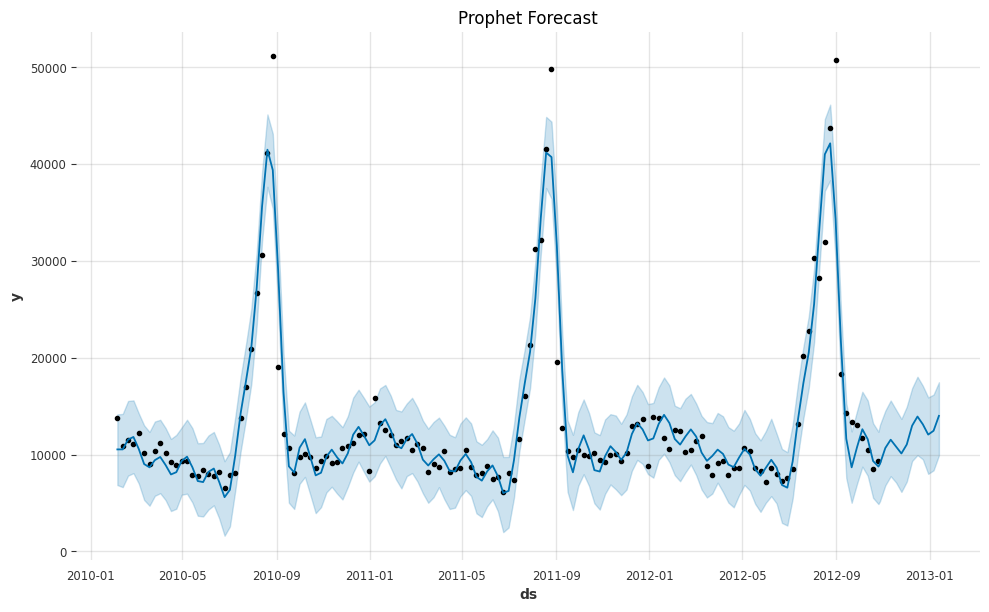

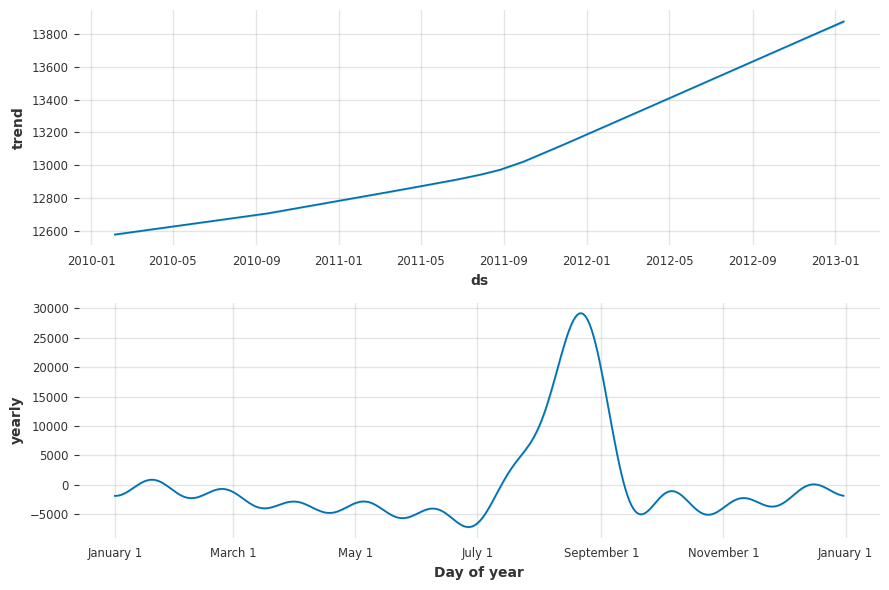

In [72]:
# Plot Forecast
model_prophet.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

model_prophet.plot_components(forecast)
plt.show()


In [73]:
# Evaluate Prophet

forecast_tail = forecast.set_index('ds').loc[df_prophet['ds'][-12:].values]
y_true = df_prophet.set_index('ds')['y'][-12:]
y_pred = forecast_tail['yhat']

print("Prophet:", evaluate(y_true, y_pred))


Prophet: (5984.157786551254, 4059.0125376019764, 17.212724631589207)


# Innovative Technique

In [74]:
pip install darts


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

N-BEATS RMSE: 10678.08745013959
N-BEATS MAPE: 26.980818660388618


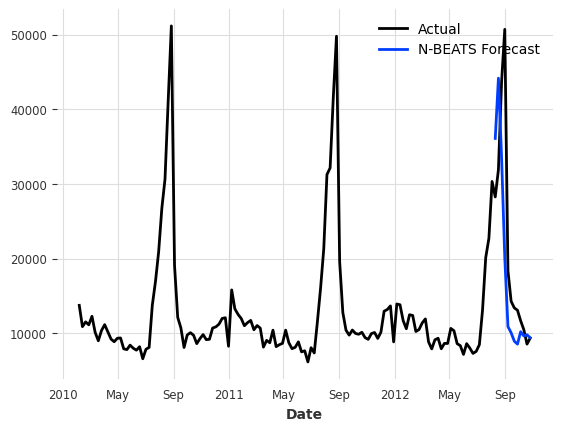

In [75]:
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import rmse, mape

from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

# Reformat
series = TimeSeries.from_dataframe(df_dept3.reset_index(), time_col='Date', value_cols='Weekly_Sales')

# Scale
scaler = Scaler()
series_scaled = scaler.fit_transform(series)

# Train/Test
train_nbeats, val_nbeats = series_scaled[:-12], series_scaled[-12:]

# Create Model
model_nbeats = NBEATSModel(input_chunk_length=36, output_chunk_length=12, n_epochs=100, random_state=42)

model_nbeats.fit(train_nbeats, verbose=False)

# Forecast
forecast_nbeats = model_nbeats.predict(n=12)

# Inverse scale
forecast_nbeats_inv = scaler.inverse_transform(forecast_nbeats)
val_nbeats_inv = scaler.inverse_transform(val_nbeats)

# Evaluation
print("N-BEATS RMSE:", rmse(val_nbeats_inv, forecast_nbeats_inv))
print("N-BEATS MAPE:", mape(val_nbeats_inv, forecast_nbeats_inv))

# Plot
series.plot(label='Actual')
forecast_nbeats_inv.plot(label='N-BEATS Forecast')
plt.legend()
plt.show()


# Final Comparison Table

In [76]:
import pandas as pd

results = {
    'Model': ['Holt', 'Holt-Winters', 'ARIMA', 'SARIMA', 'SARIMAX',
              'Random Forest', 'XGBoost', 'ANN', 'LSTM', 'Prophet'],
    'RMSE': [
        21953.99, 9821.14, 12157.13, 9707.89, 9716.27,
        6170.51, 2373.46, 11196.41, 11710.75, 5984.16
    ],
    'MAE': [
        19526.56, 5804.87, 6707.45, 5719.02, 5605.42,
        4158.73, 1673.63, 7999.86, 7301.32, 4059.01
    ],
    'MAPE': [
        156.18, 21.20, 23.88, 21.03, 20.70,
        15.77, 8.27, 36.31, 29.92, 17.21
    ]
}

df_results = pd.DataFrame(results)
print(df_results.sort_values(by='RMSE'))


           Model      RMSE       MAE    MAPE
6        XGBoost   2373.46   1673.63    8.27
9        Prophet   5984.16   4059.01   17.21
5  Random Forest   6170.51   4158.73   15.77
3         SARIMA   9707.89   5719.02   21.03
4        SARIMAX   9716.27   5605.42   20.70
1   Holt-Winters   9821.14   5804.87   21.20
7            ANN  11196.41   7999.86   36.31
8           LSTM  11710.75   7301.32   29.92
2          ARIMA  12157.13   6707.45   23.88
0           Holt  21953.99  19526.56  156.18


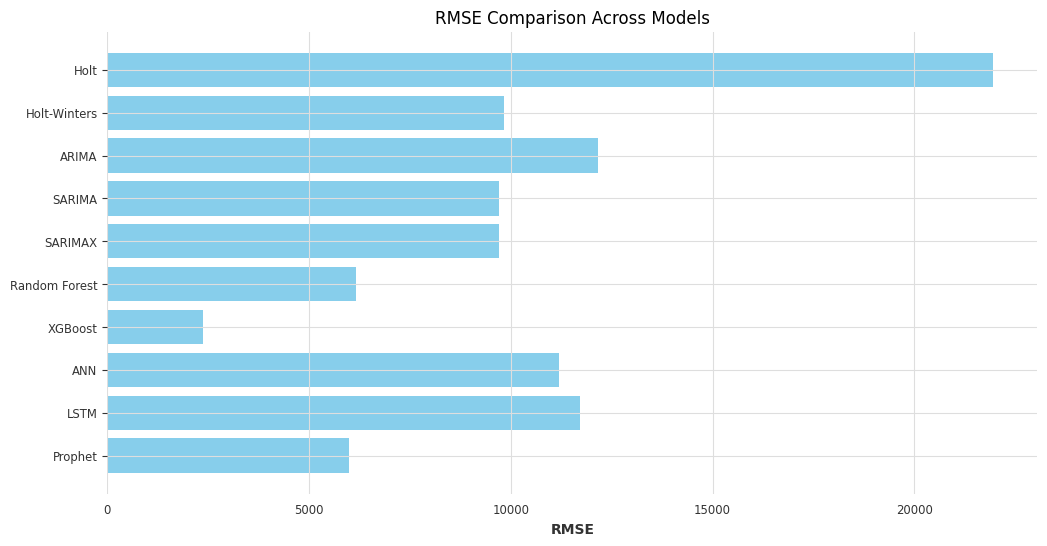

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(df_results['Model'], df_results['RMSE'], color='skyblue')
plt.title('RMSE Comparison Across Models')
plt.xlabel('RMSE')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


In [33]:
import joblib

# Save the model
joblib.dump(xgb_model, 'xgboost_model.pkl')
print("Model saved as xgboost_model.pkl")


Model saved as xgboost_model.pkl
